In [1]:
import pandas as pd
import numpy as np

cols= ['Q{}'.format(idx) for idx in range(1,11)]
data= pd.read_csv('IRT//ouirt.dat', sep= ' ', names= cols)
data.head(2)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
NaN,0,1,1,1,1,1,1,1,1,0
NaN,0,1,0,0,1,0,1,0,0,0


In [2]:
data= pd.DataFrame(data.values, columns=cols)
data.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.150000,0.268000,0.318000,0.296000,0.438000,0.314000,0.412000,0.334000,0.318000,0.070000
std,0.357429,0.443361,0.466166,0.456948,0.496638,0.464581,0.492688,0.472112,0.466166,0.255403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


*  Truncating Question items to 3

In [3]:
rel_items = cols[:3]#Q1,Q2,Q3
df = data[rel_items]
df.head(3)

,Q1,Q2,Q3
0,0,1,1
1,0,1,0
2,0,0,0


In [4]:
df_cols = ['user','questions', 'response']#final dataframe cols

In [5]:
#pd.DataFrame({'user': list(range(df.shape[0]*3)), 
# 'questions':['Q1']*500+ ['Q2']*500+ ['Q3']*500,'response':pd.concat([df[feat_cols[0]],
# df[feat_cols[1]], df[feat_cols[2]]]).values})

In [6]:
from collections import defaultdict
di = defaultdict(dict)
for idx in rel_items:
    di[idx].update(zip(range(df.shape[0]), df[idx].values))#makes format {'Q1':{user:responses,1:0,2:0,. . .,}}

* Following dataframe contains-- user id, questions id, corresponding response value

In [7]:
df_list= list()
for ques, user_resp in list(zip(di.keys(), di.values())):
    df_list.append({'user':list(user_resp.keys()), 'questions':[ques]*df.shape[0], 'response':list(user_resp.values())})

df1=pd.DataFrame(df_list[0])
df2=pd.DataFrame(df_list[1])
df3=pd.DataFrame(df_list[2])
df_new= pd.concat([df1,df2,df3], ignore_index=True)
df_new = df_new.loc[np.random.randint(0,1499, size=1500)]#shuffling data
df_new

,user,questions,response
1432,432,Q3,0
863,363,Q2,0
42,42,Q1,0
940,440,Q2,0
211,211,Q1,0
...,...,...,...
289,289,Q1,0
427,427,Q1,0
1127,127,Q3,1
95,95,Q1,1


### Defining Keras equivalent model

In [8]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras import metrics
from keras.utils import to_categorical

Using TensorFlow backend.
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kev/Desktop/pyvirtual2/lib/pytho

In [9]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df_new[df_cols[:-1]], df_new[df_cols[-1]], test_size=0.05)

In [10]:
x_train_user = to_categorical(xtrain['user'])#contains the one-hot encoded user data
x_train_questions = pd.get_dummies(xtrain['questions']).values#contains the one-hot encoded questions

y_train= ytrain.values
print('shape of x_train_user:', x_train_user.shape,'\nshape of x_train_questions:', x_train_questions.shape,
      '\nshape of y_train:',y_train.shape)

shape of x_train_user: (1425, 500) 
shape of x_train_questions: (1425, 3) 
shape of y_train: (1425,)


### 1 PL IRT model:
* tj= Degree of latent trait
* bj= difficulty_level

`P(i=1,f(tj, bj)) = Simoid[(tj - bj)]`

In [11]:
user_input_layer = Input(shape=(x_train_user.shape[1],))#top half of input taking input feature 1
quest_input_layer = Input(shape=(x_train_questions.shape[1],))#bottom half of input taking input feature 2

latent_trait = Dense(1, use_bias=False)(user_input_layer)
difficulty_level = Dense(1, use_bias=False)(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract()([latent_trait, difficulty_level])


prediction_output = Dense(1, activation='sigmoid')(latent_difficulty_subtract)

model1 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)

model1.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            500         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            3           input_2[0][0]                    
____________________________________________________________________________________________

In [13]:
history= model1.fit(x=[x_train_user,x_train_questions], y=y_train, epochs=8, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 1140 samples, validate on 285 samples
Epoch 1/8
1140/1140 [==============================] - 0s 155us/step - loss: 0.7119 - mae: 0.5034 - accuracy: 0.3579 - val_loss: 0.6856 - val_mae: 0.4900 - val_accuracy: 0.4596
Epoch 2/8
1140/1140 [==============================] - 0s 50us/step - loss: 0.6850 - mae: 0.4899 - accuracy: 0.4596 - val_loss: 0.6633 - val_mae: 0.4780 - val_accuracy: 0.5614
Epoch 3/8
1140/1140 [==============================] - 0s 63us/step - loss: 0.6627 - mae: 0.4776 - accuracy: 0.5956 - val_loss: 0.6452 - val_mae: 0.4672 - val_accuracy: 0.7053
Epoch 4/8
1140/1140 [==============================] - 0s 68us/step - loss: 0.6444 - mae: 0.4666 - accuracy: 0.7632 - val_loss: 0.6303 - val_mae: 0.4576 - val_accuracy: 0.7614
Epoch 5/8
1140/1140 [==============================] - 0s 62us/step - loss: 0.6292 - mae: 0.4567 - accuracy: 0.7711 - val_loss: 0.6180 - val_mae: 0.4490 - val_accuracy: 0.7614
Epoch 6/8
1140/1140 [===

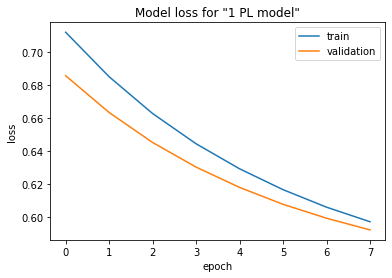

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for "1 PL model"')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()

### 2 PL IRT model
* tj= Degree of latent trait
* bj= difficulty level
* aj= discrimination parameter

`P{i=1,f(tj, bj)} = Simoid[aj(tj - bj)]`

In [17]:
user_input_layer = Input(shape=(x_train_user.shape[1],))#top half of input taking input feature 1
quest_input_layer = Input(shape=(x_train_questions.shape[1],))#bottom half of input taking input feature 2

latent_trait = Dense(1, use_bias=False)(user_input_layer)

difficulty_level = Dense(1, use_bias=False)(quest_input_layer)
discrimination_param = Dense(1, use_bias=False)(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract()([latent_trait, difficulty_level])

disc_param_interaction = keras.layers.Multiply()([latent_difficulty_subtract, 
                                                    discrimination_param])


prediction_output = Dense(1, activation='sigmoid')(disc_param_interaction)

model2 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)

model2.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

In [18]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1)            500         input_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1)            3           input_4[0][0]                    
____________________________________________________________________________________________

In [19]:
history= model2.fit(x=[x_train_user,x_train_questions], y=y_train, epochs=8, verbose=1, validation_split=0.2)

Train on 1140 samples, validate on 285 samples
Epoch 1/8
1140/1140 [==============================] - 0s 180us/step - loss: 0.6675 - mae: 0.4780 - accuracy: 0.5868 - val_loss: 0.6483 - val_mae: 0.4664 - val_accuracy: 0.6596
Epoch 2/8
1140/1140 [==============================] - 0s 40us/step - loss: 0.6505 - mae: 0.4672 - accuracy: 0.7526 - val_loss: 0.6342 - val_mae: 0.4569 - val_accuracy: 0.7614
Epoch 3/8
1140/1140 [==============================] - 0s 45us/step - loss: 0.6364 - mae: 0.4578 - accuracy: 0.7711 - val_loss: 0.6226 - val_mae: 0.4484 - val_accuracy: 0.7614
Epoch 4/8
1140/1140 [==============================] - 0s 63us/step - loss: 0.6245 - mae: 0.4494 - accuracy: 0.7711 - val_loss: 0.6128 - val_mae: 0.4407 - val_accuracy: 0.7614
Epoch 5/8
1140/1140 [==============================] - 0s 49us/step - loss: 0.6144 - mae: 0.4413 - accuracy: 0.7711 - val_loss: 0.6047 - val_mae: 0.4339 - val_accuracy: 0.7614
Epoch 6/8
1140/1140 [==============================] - 0s 48us/step - lo

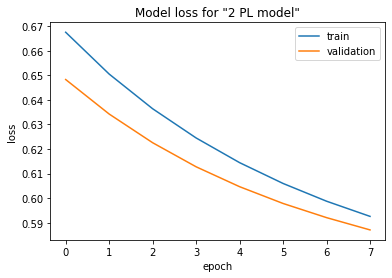

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for "2 PL model"')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()

### 3 PL IRT model
* tj= Degree of latent trait
* bj= difficulty level
* aj= discrimination parameter
* cj= pseudo guessing parameter

`P{i=1,f(tj, bj)} = Simoid[cj+ aj(1-cj)(tj - bj)]`

In [21]:
from keras import backend as K
from keras.layers import Lambda

In [22]:
#for the purpose of Lambda layer
def ops_func(x, op='add'):
    if op=='add':
        return K.constant(value=np.array([x[0]])) + x[1]
    if op=='subtract':
        return K.constant(value=np.array([x[0]])) - x[1]
    if op=='multiply':
        return K.constant(value=np.array([x[0]]))* x[1]

In [23]:
user_input_layer = Input(shape=(x_train_user.shape[1],))#top half of input
quest_input_layer = Input(shape=(x_train_questions.shape[1],))#bottom half of input

latent_trait = Dense(1, use_bias=False)(user_input_layer)

difficulty_level = Dense(1, use_bias=False)(quest_input_layer)
discrimination_param = Dense(1, use_bias=False)(quest_input_layer)
guess_param = Dense(1, use_bias=False)(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract()([latent_trait, difficulty_level])

disc_param_interaction = keras.layers.Multiply()([latent_difficulty_subtract, 
                                                    discrimination_param])

guess_param_interaction= Lambda(lambda x: K.constant(value=np.array([-1]))*x)(guess_param)
guess_param_interaction= Lambda(lambda x: K.constant(value=np.array([1]))+ x)(guess_param_interaction)#keras.layers.Add()([K.constant(value=np.array([1])), guess_param_interaction])
guess_param_interaction= keras.layers.Multiply()([disc_param_interaction, 
                                                guess_param_interaction])

guess_param_interaction= keras.layers.Add()([guess_param, guess_param_interaction])


prediction_output = Dense(1, activation='sigmoid')(guess_param_interaction)

model3 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)
model3.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

In [24]:
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 1)            3           input_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1)            500         input_5[0][0]                    
____________________________________________________________________________________________

In [25]:
history= model3.fit(x=[x_train_user,x_train_questions], y=y_train, epochs=8, verbose=1, validation_split=0.2)

Train on 1140 samples, validate on 285 samples
Epoch 1/8
1140/1140 [==============================] - 0s 239us/step - loss: 0.6864 - mae: 0.4959 - accuracy: 0.5447 - val_loss: 0.6709 - val_mae: 0.4879 - val_accuracy: 0.6035
Epoch 2/8
1140/1140 [==============================] - 0s 46us/step - loss: 0.6624 - mae: 0.4832 - accuracy: 0.7623 - val_loss: 0.6510 - val_mae: 0.4767 - val_accuracy: 0.7614
Epoch 3/8
1140/1140 [==============================] - 0s 44us/step - loss: 0.6427 - mae: 0.4718 - accuracy: 0.7711 - val_loss: 0.6345 - val_mae: 0.4666 - val_accuracy: 0.7614
Epoch 4/8
1140/1140 [==============================] - 0s 54us/step - loss: 0.6261 - mae: 0.4614 - accuracy: 0.7711 - val_loss: 0.6207 - val_mae: 0.4574 - val_accuracy: 0.7614
Epoch 5/8
1140/1140 [==============================] - 0s 49us/step - loss: 0.6123 - mae: 0.4521 - accuracy: 0.7711 - val_loss: 0.6093 - val_mae: 0.4490 - val_accuracy: 0.7614
Epoch 6/8
1140/1140 [==============================] - 0s 52us/step - lo

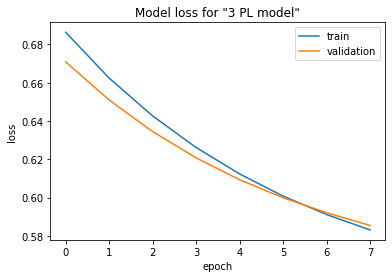

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for "3 PL model"')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()